# OBP Library Workshop Tutorials

## Synthetic Data

In [ ]:
!pip install obp==0.5.1
!pip install matplotlib==3.1.1

In [1]:
from sklearn.linear_model import LogisticRegression

import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_behavior_policy,
)
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    DirectMethod as DM,
    DoublyRobust as DR,
)

### Generate Synthetic Dataset

`obp.dataset.SyntheticBanditDataset` is an easy-to-use synthetic data generator.

It takes 
- number of actions (`n_actions`, $|\mathcal{A}|$)
- dimension of context vectors (`dim_context`, $d$)
- reward function (`reward_function`, $q(x,a)=\mathbb{E}[r \mid x,a]$)
- behavior policy (`behavior_policy_function`, $\pi_b(a|x)$) 

as inputs and generates synthetic logged bandit data that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`) and OPE estimators.

In [2]:
# generate synthetic logged bandit data with 10 actions
# we use `logistic function` as the reward function and `linear_behavior_policy` as the behavior policy.
# one can define their own reward function and behavior policy such as nonlinear ones. 
dataset = SyntheticBanditDataset(
    n_actions=10, # number of actions; |A|
    dim_context=5, # number of dimensions of context vector
    reward_function=logistic_reward_function, # mean reward function; q(x,a)
    behavior_policy_function=linear_behavior_policy, # behavior policy; \pi_b
    random_state=12345,

)
training_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=10000)
test_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=1000000)

training_bandit_data

{'action': array([9, 2, 1, ..., 0, 2, 6]),
 'action_context': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 'context': array([[-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057],
        [ 1.39340583,  0.09290788,  0.28174615,  0.76902257,  1.24643474],
        [ 1.00718936, -1.29622111,  0.27499163,  0.22891288,  1.35291684],
        ...,
        [-1.27028221,  0.80914602, -0.45084222,  0.47179511,  1.89401115],
        [-0.68890924,  0.08857502, -0.56359347, -0.41135069,  0.65157486],
        [ 0.51204121,  0.65384817, -1.98849253, -2.14429131, -0.34186901]]),
 'expected_reward': array([[0.80210203, 0.73828559, 0.8319955

the logged bandit feedback is collected by the behavior policy as follows.

$ \mathcal{D}_b := \{(x_i,a_i,r_i)\}$  where $(x,a,r) \sim p(x)\pi_b(a \mid x)p(r \mid x,a) $

### Train Bandit Policies (OPL)

In [3]:
ipw_learner = IPWLearner(
    n_actions=dataset.n_actions, # number of actions; |A|
    base_classifier=LogisticRegression(C=100, random_state=12345) # any sklearn classifier
)

# fit
ipw_learner.fit(
    context=training_bandit_data["context"], # context; x
    action=training_bandit_data["action"], # action; a
    reward=training_bandit_data["reward"], # reward; r
    pscore=training_bandit_data["pscore"], # propensity score; pi_b(a|x)
)

# predict (action dist = action distribution)
action_dist_ipw = ipw_learner.predict(
    context=test_bandit_data["context"], # context in the test data
)

action_dist_ipw[:, :, 0] # which action to take for each context 

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Approximate the Ground-truth Policy Value

$$ V(\pi) \approx \frac{1}{|\mathcal{D}_{te}|} \sum_{i=1}^{|\mathcal{D}_{te}|} \mathbb{E}_{a \sim \pi(a|x_i)} [r(x_i, a)], \; \, where \; \, r(x,a) := \mathbb{E}_{r \sim p(r|x,a)} [r] $$

In [4]:
policy_value_of_ipw = dataset.calc_ground_truth_policy_value(
    expected_reward=test_bandit_data["expected_reward"], # expected rewards; q(x,a)
    action_dist=action_dist_ipw, # action distribution of IPWLearner
)

# ground-truth policy value of `IPWLearner`
policy_value_of_ipw

0.7544002774485176

### Obtain a Reward Estimator

obp.ope.RegressionModel simplifies the process of reward modeling

$ r(x,a)=E[r∣x,a]≈r^(x,a) $

In [5]:
# estimate the expected reward by using an ML model (Logistic Regression here)
# the estimated rewards are used by model-dependent estimators such as DM and DR
regression_model = RegressionModel(
    n_actions=dataset.n_actions, # number of actions; |A|
    base_model=LogisticRegression(C=100, random_state=12345) # any sklearn classifier
)

estimated_rewards = regression_model.fit_predict(
    context=test_bandit_data["context"], # context; x
    action=test_bandit_data["action"], # action; a
    reward=test_bandit_data["reward"], # reward; r
    random_state=12345,
)

estimated_rewards[:, :, 0] # \hat{q}(x,a)

array([[0.83287191, 0.77609002, 0.86301082, ..., 0.80705541, 0.87089962,
        0.88661944],
       [0.24064512, 0.18060694, 0.28603087, ..., 0.21010776, 0.30020355,
        0.33212285],
       [0.92681158, 0.89803854, 0.94120582, ..., 0.91400784, 0.94487921,
        0.95208655],
       ...,
       [0.95590514, 0.93780227, 0.96479479, ..., 0.94790501, 0.96704598,
        0.97144249],
       [0.9041431 , 0.8677301 , 0.92262342, ..., 0.88785354, 0.92736823,
        0.93671186],
       [0.19985698, 0.14801146, 0.23998121, ..., 0.1733142 , 0.25267968,
        0.28157917]])

please refer to https://arxiv.org/abs/2002.08536 about the details of the cross-fitting procedure.

### Off-Policy Evaluation (OPE)

obp.ope.OffPolicyEvaluation simplifies the OPE process

$ V(πe)≈\hat{V}(πe;D0,θ) $ using DM, IPS, and DR

In [6]:
ope = OffPolicyEvaluation(
    bandit_feedback=test_bandit_data, # test data
    ope_estimators=[
        IPS(estimator_name="IPS"), 
        DM(estimator_name="DM"), 
        DR(estimator_name="DR"),
    ] # used estimators
)

estimated_policy_value = ope.estimate_policy_values(
    action_dist=action_dist_ipw, # \pi_e(a|x)
    estimated_rewards_by_reg_model=estimated_rewards, # \hat{q}(x,a)
)

# OPE results given by the three estimators
estimated_policy_value

{'DM': 0.649636379816842, 'DR': 0.7515054724486265, 'IPS': 0.7514146726298303}

         mean  95.0% CI (lower)  95.0% CI (upper)
IPS  0.751658          0.745758          0.756950
DM   0.649630          0.649152          0.650020
DR   0.751348          0.748093          0.754105 



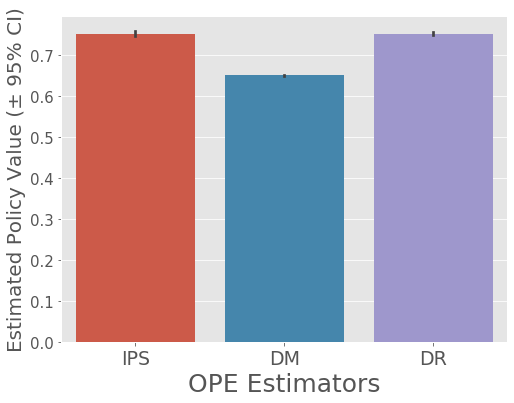

In [11]:
# estimate the policy value of IPWLearner with Logistic Regression
estimated_policy_value_a, estimated_interval_a = ope.summarize_off_policy_estimates(
    action_dist=action_dist_ipw,
    estimated_rewards_by_reg_model=estimated_rewards
)
print(estimated_interval_a, '\n')

# visualize policy values of IPWLearner with Logistic Regression estimated by the three OPE estimators
ope.visualize_off_policy_estimates(
    action_dist=action_dist_ipw,
    estimated_rewards_by_reg_model=estimated_rewards,
    n_bootstrap_samples=1000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

### Evaluation of OPE

Now, let's evaluate the OPE performance (estimation accuracy) of the three estimators

$ V(\pi_e) \approx \hat{V} (\pi_e; \mathcal{D}_0, \theta) $

We can then evaluate the estimation performance of OPE estimators by comparing the estimated policy values of the evaluation with its ground-truth as follows.

- $\textit{relative-ee} (\hat{V}; \mathcal{D}_b) := \left| \frac{V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b)}{V(\pi_e)} \right|$ (relative estimation error; relative-ee)
- $\textit{SE} (\hat{V}; \mathcal{D}_b) := \left( V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b) \right)^2$ (squared error; se)

In [7]:
squared_errors = ope.evaluate_performance_of_estimators(
    ground_truth_policy_value=policy_value_of_ipw, # V(\pi_e)
    action_dist=action_dist_ipw, # \pi_e(a|x)
    estimated_rewards_by_reg_model=estimated_rewards, # \hat{q}(x,a)
    metric="se", # squared error
)

squared_errors # DR is the most accurate

{'DM': 0.010975474246980203,
 'DR': 8.379895987394117e-06,
 'IPS': 8.913836133368584e-06}

We can iterate the above process several times and calculate the following MSE

$ MSE (\hat{V}) := T^{-1} \sum_{t=1}^T SE (\hat{V}; \mathcal{D}_0^{(t)}) $ 

where $ \mathcal{D}_0^{(t)} $ is the synthetic data in the t-th iteration

## Off-Policy Simulation Data

### Imports

In [ ]:
import time

import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_behavior_policy
)
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    SelfNormalizedInverseProbabilityWeighting as SNIPS,
    DirectMethod as DM,
    DoublyRobust as DR,
    DoublyRobustWithShrinkage as DRos,
    DoublyRobustWithShrinkageTuning as DRosTuning,
)
from obp.utils import softmax

import warnings
warnings.simplefilter('ignore')

### Evaluatin of OPE estimators (Part 1; easy setting)

In [ ]:
### configurations
num_runs = 200
num_data_list = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200]

In [ ]:
### define a dataset class
dataset = SyntheticBanditDataset(
    n_actions=10, 
    dim_context=10,
    tau=0.2, 
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=12345,
)
#### training data is used to train an evaluation policy
train_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=5000)
#### test bandit data is used to approximate the ground-truth policy value
test_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=100000)

In [ ]:
### evaluation policy training
ipw_learner = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=RandomForestClassifier(random_state=12345),
)
ipw_learner.fit(
    context=train_bandit_data["context"], 
    action=train_bandit_data["action"], 
    reward=train_bandit_data["reward"], 
    pscore=train_bandit_data["pscore"], 
)
action_dist_ipw_test = ipw_learner.predict(
    context=test_bandit_data["context"],
)
policy_value_of_ipw = dataset.calc_ground_truth_policy_value(
    expected_reward=test_bandit_data["expected_reward"], 
    action_dist=action_dist_ipw_test, 
)

In [ ]:
### evaluation of OPE estimators
se_df_list = []
for num_data in num_data_list:
    se_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ### generate validation data
        validation_bandit_data = dataset.obtain_batch_bandit_feedback(
            n_rounds=num_data
        )

        ### make decisions on vlidation data
        action_dist_ipw_val = ipw_learner.predict(
            context=validation_bandit_data["context"],
        )

        ### OPE using validation data
        regression_model = RegressionModel(
            n_actions=dataset.n_actions, 
            base_model=LogisticRegression(C=100, max_iter=10000, random_state=12345),
        )
        estimated_rewards = regression_model.fit_predict(
            context=validation_bandit_data["context"], # context; x
            action=validation_bandit_data["action"], # action; a
            reward=validation_bandit_data["reward"], # reward; r
            n_folds=2, # 2-fold cross fitting
            random_state=12345,
        )
        ope = OffPolicyEvaluation(
            bandit_feedback=validation_bandit_data,
            ope_estimators=[
                IPS(estimator_name="IPS"), 
                DM(estimator_name="DM"), 
                IPS(lambda_=5, estimator_name="CIPS"), 
                SNIPS(estimator_name="SNIPS"),
                DR(estimator_name="DR"), 
                DRos(lambda_=500, estimator_name="DRos"), 
            ]
        )
        squared_errors = ope.evaluate_performance_of_estimators(
            ground_truth_policy_value=policy_value_of_ipw, # V(\pi_e)
            action_dist=action_dist_ipw_val, # \pi_e(a|x)
            estimated_rewards_by_reg_model=estimated_rewards, # \hat{q}(x,a)
            metric="se", # squared error
        )
        se_list.append(squared_errors)
    ### maximum importance weight in the validation data
    #### a larger value indicates that the logging and evaluation policies are greatly different
    max_iw = (action_dist_ipw_val[
        np.arange(validation_bandit_data["n_rounds"]), 
        validation_bandit_data["action"], 
        0
    ] / validation_bandit_data["pscore"]).max()
    tqdm.write(f"maximum importance weight={np.round(max_iw, 5)}\n")

    ### summarize results
    se_df = DataFrame(DataFrame(se_list).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "se"})
    se_df["num_data"] = num_data
    se_df_list.append(se_df)
    tqdm.write("=====" * 15)
    time.sleep(0.5)

# aggregate all results 
result_df = pd.concat(se_df_list).reset_index(level=0)

num_data=100...: 100%|██████████| 200/200 [00:10<00:00, 18.22it/s]


maximum importance weight=6.32599



num_data=200...: 100%|██████████| 200/200 [00:09<00:00, 20.21it/s]


maximum importance weight=6.32599



num_data=400...: 100%|██████████| 200/200 [00:10<00:00, 18.76it/s]


maximum importance weight=8.6407



num_data=800...: 100%|██████████| 200/200 [00:15<00:00, 12.92it/s]


maximum importance weight=18.60611



num_data=1600...: 100%|██████████| 200/200 [00:30<00:00,  6.66it/s]


maximum importance weight=13.29143



num_data=3200...: 100%|██████████| 200/200 [00:40<00:00,  4.96it/s]


maximum importance weight=13.29143



num_data=6400...: 100%|██████████| 200/200 [01:02<00:00,  3.22it/s]


maximum importance weight=13.29143



num_data=12800...: 100%|██████████| 200/200 [01:42<00:00,  1.95it/s]


maximum importance weight=18.60611



num_data=25600...: 100%|██████████| 200/200 [03:05<00:00,  1.08it/s]


maximum importance weight=18.60611



num_data=51200...: 100%|██████████| 200/200 [05:49<00:00,  1.75s/it]


maximum importance weight=18.60611



### Visualize Results

In [ ]:
# figure configs
query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df.query("(est == 'DM' or est == 'IPS') and num_data <= 12800"),
)
# title and legend
ax.legend(["IPS", "DM"], loc="upper right", fontsize=25)
# yaxis
ax.set_yscale("log")
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

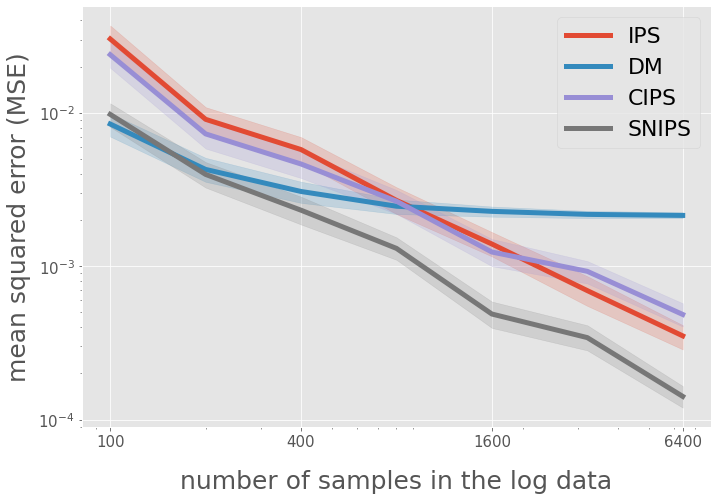

In [ ]:
# figure configs
query = "(est == 'DM' or est == 'CIPS' or est == 'IPS' or est == 'SNIPS')" 
query += "and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df.query(query),
)
# title and legend
ax.legend(["IPS", "DM", "CIPS", "SNIPS"], loc="upper right", fontsize=22)
# yaxis
ax.set_yscale("log")
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

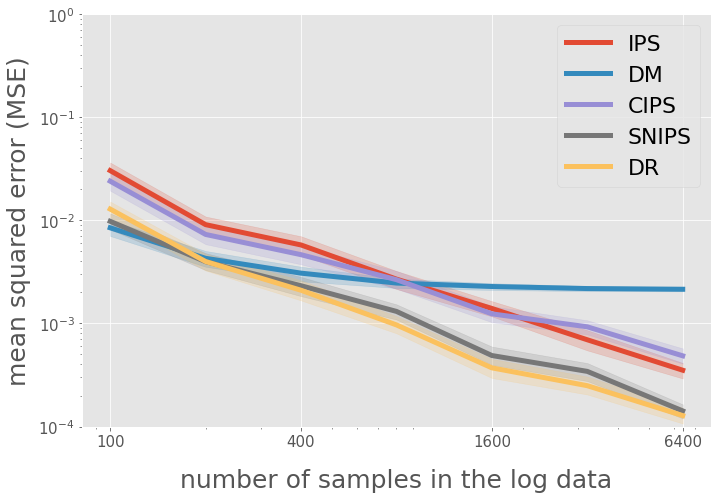

In [ ]:
# figure configs
query = "(est == 'DM' or est == 'IPS' or est == 'SNIPS' or est == 'CIPS' or est == 'DR')"
query += "and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df.query(query),
)
# title and legend
ax.legend(["IPS", "DM", "CIPS", "SNIPS", "DR"], loc="upper right", fontsize=22)
# yaxis
ax.set_yscale("log")
ax.set_ylim(1e-4, 1)
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

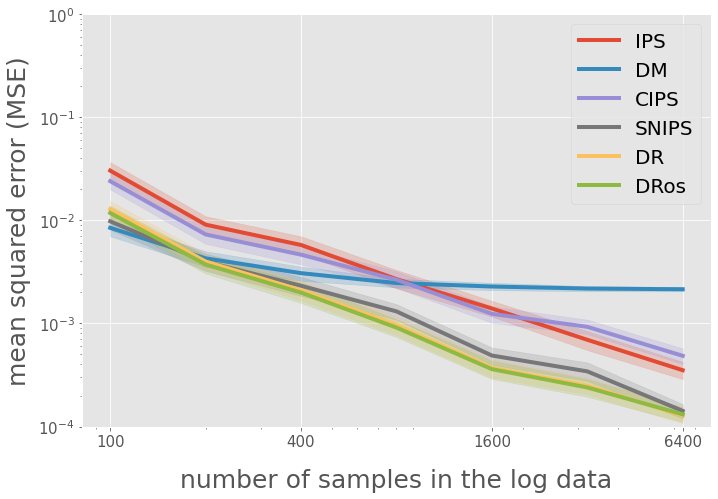

In [ ]:
# figure configs
query = "num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=4,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df.query(query),
)
# title and legend
ax.legend(["IPS", "DM", "CIPS", "SNIPS", "DR", "DRos"], loc="upper right", fontsize=20)
# yaxis
ax.set_yscale("log")
ax.set_ylim(1e-4, 1)
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

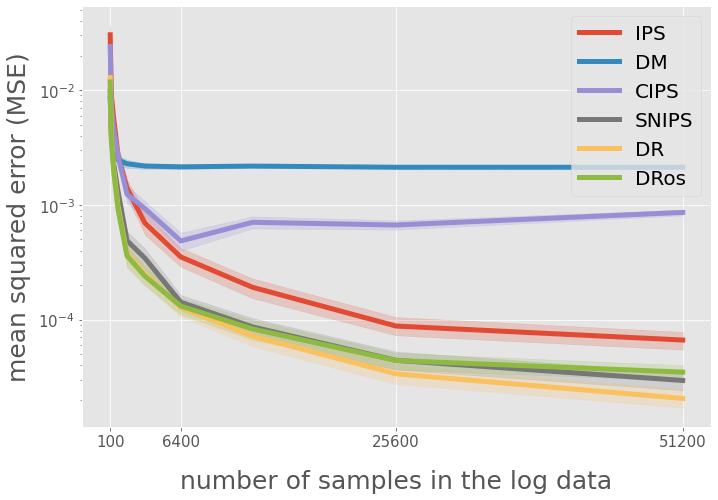

In [ ]:
xlabels = [100, 6400, 25600, 51200]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df,
)
# title and legend
ax.legend(["IPS", "DM", "CIPS", "SNIPS", "DR", "DRos"], loc="upper right", fontsize=20)
# yaxis
ax.set_yscale("log")
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

### Evaluation of OPE estimators (Part 2; challenging setting)

In [ ]:
### configurations
num_runs = 200
num_data_list = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200]

In [ ]:
### define a dataset class
dataset = SyntheticBanditDataset(
    n_actions=10, 
    dim_context=10,
    tau=0.2, 
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=12345,
)
#### training data is used to train an evaluation policy
train_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=5000)
#### test bandit data is used to approximate the ground-truth policy value
test_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=100000)

In [ ]:
### evaluation policy training
ipw_learner = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=LogisticRegression(C=100, max_iter=10000, random_state=12345)
)
ipw_learner.fit(
    context=train_bandit_data["context"], 
    action=train_bandit_data["action"], 
    reward=train_bandit_data["reward"], 
    pscore=train_bandit_data["pscore"], 
)
action_dist_ipw_test = ipw_learner.predict(
    context=test_bandit_data["context"],
)
policy_value_of_ipw = dataset.calc_ground_truth_policy_value(
    expected_reward=test_bandit_data["expected_reward"], 
    action_dist=action_dist_ipw_test, 
)

In [ ]:
### evaluation of OPE estimators
se_df_list = []
for num_data in num_data_list:
    se_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ### generate validation data
        validation_bandit_data = dataset.obtain_batch_bandit_feedback(
            n_rounds=num_data
        )

        ### make decisions on vlidation data
        action_dist_ipw_val = ipw_learner.predict(
            context=validation_bandit_data["context"],
        )

        ### OPE using validation data
        regression_model = RegressionModel(
            n_actions=dataset.n_actions, 
            base_model=LogisticRegression(C=100, max_iter=10000, random_state=12345),
        )
        estimated_rewards = regression_model.fit_predict(
            context=validation_bandit_data["context"], # context; x
            action=validation_bandit_data["action"], # action; a
            reward=validation_bandit_data["reward"], # reward; r
            n_folds=2, # 2-fold cross fitting
            random_state=12345,
        )
        ope = OffPolicyEvaluation(
            bandit_feedback=validation_bandit_data,
            ope_estimators=[
                IPS(estimator_name="IPS"), 
                DM(estimator_name="DM"), 
                IPS(lambda_=100, estimator_name="CIPS"), 
                SNIPS(estimator_name="SNIPS"),
                DR(estimator_name="DR"), 
                DRos(lambda_=500, estimator_name="DRos"), 
            ]
        )
        squared_errors = ope.evaluate_performance_of_estimators(
            ground_truth_policy_value=policy_value_of_ipw, # V(\pi_e)
            action_dist=action_dist_ipw_val, # \pi_e(a|x)
            estimated_rewards_by_reg_model=estimated_rewards, # \hat{q}(x,a)
            metric="se", # squared error
        )
        se_list.append(squared_errors)
    ### maximum importance weight in the validation data
    #### a larger value indicates that the logging and evaluation policies are greatly different
    max_iw = (action_dist_ipw_val[
        np.arange(validation_bandit_data["n_rounds"]), 
        validation_bandit_data["action"], 
        0
    ] / validation_bandit_data["pscore"]).max()
    tqdm.write(f"maximum importance weight={np.round(max_iw, 5)}\n")

    ### summarize results
    se_df = DataFrame(DataFrame(se_list).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "se"})
    se_df["num_data"] = num_data
    se_df_list.append(se_df)
    tqdm.write("=====" * 15)
    time.sleep(0.5)

# aggregate all results 
result_df = pd.concat(se_df_list).reset_index(level=0)

num_data=100...: 100%|██████████| 200/200 [00:08<00:00, 24.35it/s]


maximum importance weight=18.60611



num_data=200...: 100%|██████████| 200/200 [00:06<00:00, 30.96it/s]


maximum importance weight=18.60611



num_data=400...: 100%|██████████| 200/200 [00:05<00:00, 35.05it/s]


maximum importance weight=291.00022



num_data=800...: 100%|██████████| 200/200 [00:08<00:00, 23.55it/s]


maximum importance weight=475.13758



num_data=1600...: 100%|██████████| 200/200 [00:16<00:00, 12.32it/s]


maximum importance weight=475.13758



num_data=3200...: 100%|██████████| 200/200 [00:18<00:00, 10.67it/s]


maximum importance weight=475.13758



num_data=6400...: 100%|██████████| 200/200 [00:27<00:00,  7.28it/s]


maximum importance weight=475.13758



num_data=12800...: 100%|██████████| 200/200 [00:43<00:00,  4.63it/s]


maximum importance weight=475.13758



num_data=25600...: 100%|██████████| 200/200 [01:16<00:00,  2.62it/s]


maximum importance weight=475.13758



num_data=51200...: 100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


maximum importance weight=475.13758



### Visualize Results

In [ ]:
# figure configs
query = "(est == 'DM' or est == 'IPS' or est == 'SNIPS' or est == 'CIPS' or est == 'DR')"
query += "and num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df.query(query),
)
# title and legend
ax.legend(["IPS", "DM", "CIPS", "SNIPS", "DR"], loc="upper right", fontsize=22)
# yaxis
ax.set_yscale("log")
ax.set_ylim(1e-4, 1)
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

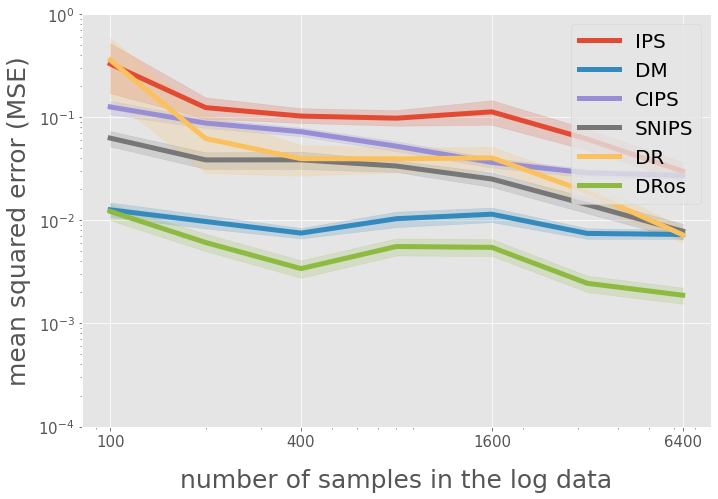

In [ ]:
query = "num_data <= 6400"
xlabels = [100, 400, 1600, 6400]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df.query(query),
)
# title and legend
ax.legend(["IPS", "DM", "CIPS", "SNIPS", "DR", "DRos"], loc="upper right", fontsize=20)
# yaxis
ax.set_yscale("log")
ax.set_ylim(1e-4, 1)
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

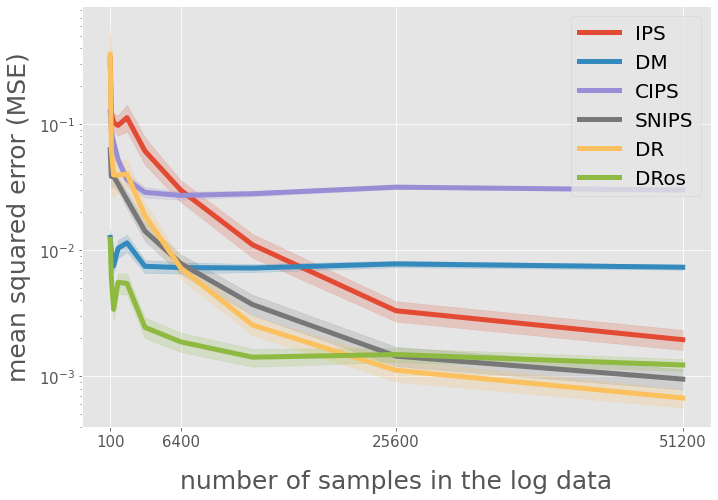

In [ ]:
xlabels = [100, 6400, 25600, 51200]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df,
)
# title and legend
ax.legend(["IPS", "DM", "CIPS", "SNIPS", "DR", "DRos"], loc="upper right", fontsize=20)
# yaxis
ax.set_yscale("log")
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

### Hyperparameter Tuning of OPE estimators

In [ ]:
### configurations
num_runs = 100
num_data_list = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200]

In [ ]:
### define a dataset class
dataset = SyntheticBanditDataset(
    n_actions=10, 
    dim_context=10,
    tau=0.2, 
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=12345,
)
#### training data is used to train an evaluation policy
train_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=5000)
#### test bandit data is used to approximate the ground-truth policy value
test_bandit_data = dataset.obtain_batch_bandit_feedback(n_rounds=100000)

In [ ]:
### evaluation policy training
ipw_learner = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=LogisticRegression(C=100, max_iter=10000, random_state=12345)
)
ipw_learner.fit(
    context=train_bandit_data["context"], 
    action=train_bandit_data["action"], 
    reward=train_bandit_data["reward"], 
    pscore=train_bandit_data["pscore"], 
)
action_dist_ipw_test = ipw_learner.predict(
    context=test_bandit_data["context"],
)
policy_value_of_ipw = dataset.calc_ground_truth_policy_value(
    expected_reward=test_bandit_data["expected_reward"], 
    action_dist=action_dist_ipw_test, 
)

In [ ]:
### evaluation of OPE estimators
se_df_list = []
for num_data in num_data_list:
    se_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ### generate validation data
        validation_bandit_data = dataset.obtain_batch_bandit_feedback(
            n_rounds=num_data
        )

        ### make decisions on vlidation data
        action_dist_ipw_val = ipw_learner.predict(
            context=validation_bandit_data["context"],
        )

        ### OPE using validation data
        regression_model = RegressionModel(
            n_actions=dataset.n_actions, 
            base_model=LogisticRegression(C=100, max_iter=10000, random_state=12345)
        )
        estimated_rewards = regression_model.fit_predict(
            context=validation_bandit_data["context"], # context; x
            action=validation_bandit_data["action"], # action; a
            reward=validation_bandit_data["reward"], # reward; r
            n_folds=2, # 2-fold cross fitting
            random_state=12345,
        )
        ope = OffPolicyEvaluation(
            bandit_feedback=validation_bandit_data,
            ope_estimators=[
                DRos(lambda_=1, estimator_name="DRos (1)"), 
                DRos(lambda_=100, estimator_name="DRos (100)"), 
                DRos(lambda_=10000, estimator_name="DRos (10000)"),
                DRosTuning(
                    use_bias_upper_bound=False,
                    lambdas=np.arange(1, 10002, 100).tolist(), 
                    estimator_name="DRos (tuning)"
                ), 
            ]
        )
        squared_errors = ope.evaluate_performance_of_estimators(
            ground_truth_policy_value=policy_value_of_ipw, # V(\pi_e)
            action_dist=action_dist_ipw_val, # \pi_e(a|x)
            estimated_rewards_by_reg_model=estimated_rewards, # \hat{q}(x,a)
            metric="se", # squared error
        )
        se_list.append(squared_errors)
    ### maximum importance weight in the validation data
    #### a larger value indicates that the logging and evaluation policies are greatly different
    max_iw = (action_dist_ipw_val[
        np.arange(validation_bandit_data["n_rounds"]), 
        validation_bandit_data["action"], 
        0
    ] / validation_bandit_data["pscore"]).max()
    tqdm.write(f"maximum importance weight={np.round(max_iw, 5)}\n")

    ### summarize results
    se_df = DataFrame(DataFrame(se_list).stack())\
        .reset_index(1).rename(columns={"level_1": "est", 0: "se"})
    se_df["num_data"] = num_data
    se_df_list.append(se_df)
    tqdm.write("=====" * 15)
    time.sleep(0.5)

# aggregate all results 
result_df = pd.concat(se_df_list).reset_index(level=0)

num_data=100...: 100%|██████████| 100/100 [00:04<00:00, 23.82it/s]


maximum importance weight=18.60611



num_data=200...: 100%|██████████| 100/100 [00:04<00:00, 24.78it/s]


maximum importance weight=18.60611



num_data=400...: 100%|██████████| 100/100 [00:04<00:00, 24.94it/s]


maximum importance weight=18.60611



num_data=800...: 100%|██████████| 100/100 [00:05<00:00, 18.17it/s]


maximum importance weight=18.60611



num_data=1600...: 100%|██████████| 100/100 [00:09<00:00, 10.02it/s]


maximum importance weight=475.13758



num_data=3200...: 100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


maximum importance weight=475.13758



num_data=6400...: 100%|██████████| 100/100 [00:18<00:00,  5.29it/s]


maximum importance weight=475.13758



num_data=12800...: 100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


maximum importance weight=475.13758



num_data=25600...: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


maximum importance weight=475.13758



num_data=51200...: 100%|██████████| 100/100 [02:06<00:00,  1.27s/it]


maximum importance weight=475.13758



### Visualize Results

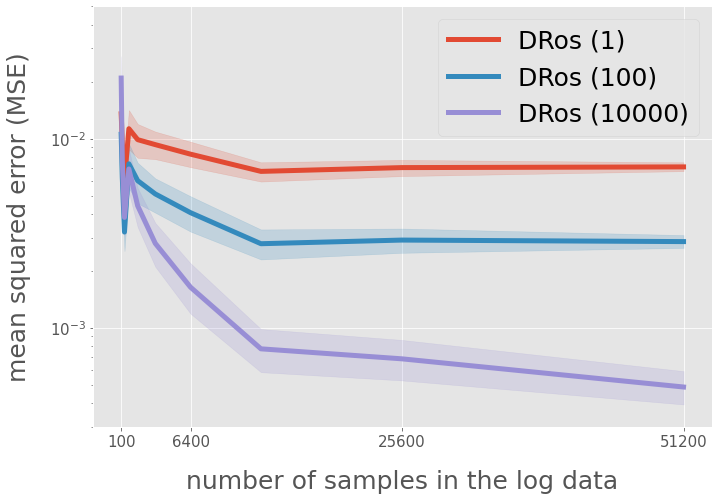

In [ ]:
query = "est == 'DRos (1)' or est == 'DRos (100)' or est == 'DRos (10000)'"
xlabels = [100, 6400, 25600, 51200]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df.query(query),
)
# title and legend
ax.legend(
    ["DRos (1)", "DRos (100)", "DRos (10000)"], 
    loc="upper right", fontsize=25,
)
# yaxis
ax.set_yscale("log")
ax.set_ylim(3e-4, 0.05)
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.1, 0.5)
# xaxis
# ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

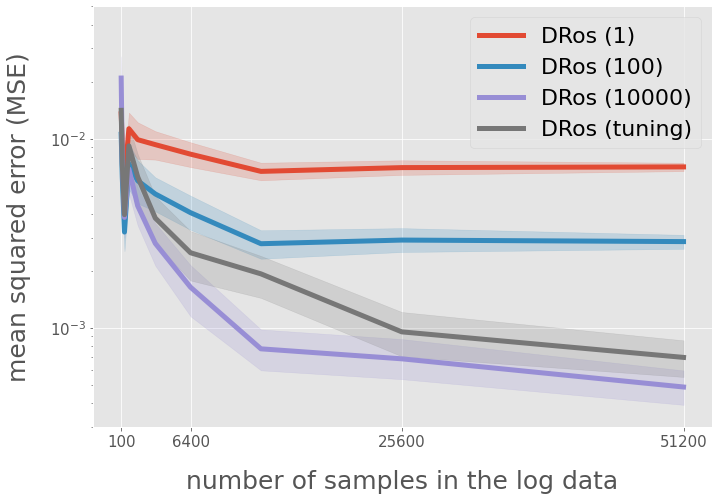

In [ ]:
xlabels = [100, 6400, 25600, 51200]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="num_data",
    y="se",
    hue="est",
    ax=ax,
    data=result_df,
)
# title and legend
ax.legend(
    ["DRos (1)", "DRos (100)", "DRos (10000)", "DRos (tuning)"], 
    loc="upper right", fontsize=22,
)
# yaxis
ax.set_yscale("log")
ax.set_ylim(3e-4, 0.05)
ax.set_ylabel("mean squared error (MSE)", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.1, 0.5)
# xaxis
# ax.set_xscale("log")
ax.set_xlabel("number of samples in the log data", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

## Multi-class Classificatoin Data

This section provides an example of conducting OPE of an evaluation policy using classification data as logged bandit data.
It is quite common to conduct OPE experiments using classification data. Appendix G of [Farajtabar et al.(2018)](https://arxiv.org/abs/1802.03493) describes how to conduct OPE experiments with classification data in detail.

In [14]:
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import obp
from obp.dataset import MultiClassToBanditReduction
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    DirectMethod as DM,
    DoublyRobust as DR, 
)

### Bandit Reduction
`obp.dataset.MultiClassToBanditReduction` is an easy-to-use for transforming classification data to bandit data.
It takes 
- feature vectors (`X`)
- class labels (`y`)
- classifier to construct behavior policy (`base_classifier_b`) 
- paramter of behavior policy (`alpha_b`) 

as its inputs and generates a bandit data that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`) and OPE estimators.

In [15]:
# load raw digits data
# `return_X_y` splits feature vectors and labels, instead of returning a Bunch object
X, y = load_digits(return_X_y=True)

In [16]:
# convert the raw classification data into a logged bandit dataset
# we construct a behavior policy using Logistic Regression and parameter alpha_b
# given a pair of a feature vector and a label (x, c), create a pair of a context vector and reward (x, r)
# where r = 1 if the output of the behavior policy is equal to c and r = 0 otherwise
# please refer to https://zr-obp.readthedocs.io/en/latest/_autosummary/obp.dataset.multiclass.html for the details
dataset = MultiClassToBanditReduction(
    X=X,
    y=y,
    base_classifier_b=LogisticRegression(max_iter=10000, random_state=12345),
    alpha_b=0.8,
    dataset_name="digits",
)

In [17]:
# split the original data into training and evaluation sets
dataset.split_train_eval(eval_size=0.7, random_state=12345)

In [18]:
# obtain logged bandit data generated by behavior policy
bandit_data = dataset.obtain_batch_bandit_feedback(random_state=12345)

# `bandit_data` is a dictionary storing logged bandit feedback
bandit_data

{'action': array([6, 8, 5, ..., 2, 5, 9]),
 'context': array([[ 0.,  0.,  0., ..., 16.,  1.,  0.],
        [ 0.,  0.,  7., ..., 16.,  3.,  0.],
        [ 0.,  0., 12., ...,  8.,  0.,  0.],
        ...,
        [ 0.,  1., 13., ...,  8., 11.,  1.],
        [ 0.,  0., 15., ...,  0.,  0.,  0.],
        [ 0.,  0.,  4., ..., 15.,  3.,  0.]]),
 'n_actions': 10,
 'n_rounds': 1258,
 'position': None,
 'pscore': array([0.82, 0.82, 0.82, ..., 0.82, 0.82, 0.82]),
 'reward': array([1., 1., 1., ..., 1., 1., 1.])}

### Off-Policy Learning
After generating logged bandit data, we now obtain an evaluation policy using the training set.

In [19]:
# obtain action choice probabilities by an evaluation policy
# we construct an evaluation policy using Random Forest and parameter alpha_e
action_dist = dataset.obtain_action_dist_by_eval_policy(
    base_classifier_e=RandomForestClassifier(random_state=12345),
    alpha_e=0.9,
)

In [20]:
# which action to take for each context (a probability distribution over actions)
action_dist[:, :, 0]

array([[0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.91, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       ...,
       [0.01, 0.01, 0.91, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.91]])

### Obtain a Reward Estimator
`obp.ope.RegressionModel` simplifies the process of reward modeling

$r(x,a) = \mathbb{E} [r \mid x, a] \approx \hat{r}(x,a)$

In [21]:
regression_model = RegressionModel(
    n_actions=dataset.n_actions, # number of actions; |A|
    base_model=LogisticRegression(C=100, max_iter=10000, random_state=12345), # any sklearn classifier
)

In [22]:
estimated_rewards = regression_model.fit_predict(
    context=bandit_data["context"],
    action=bandit_data["action"],
    reward=bandit_data["reward"],
    position=bandit_data["position"],
    random_state=12345,
)

In [23]:
estimated_rewards[:, :, 0] # \hat{q}(x,a)

array([[0.91377194, 0.87015455, 0.91602424, ..., 0.81593598, 0.89834451,
        0.93694249],
       [0.88793388, 0.8336263 , 0.8907804 , ..., 0.76821779, 0.86854866,
        0.91741997],
       [0.74709488, 0.65133633, 0.75252172, ..., 0.55271454, 0.71126924,
        0.80552132],
       ...,
       [0.81387138, 0.7344083 , 0.81821398, ..., 0.64653235, 0.78478007,
        0.85976671],
       [0.96945004, 0.95253372, 0.97029528, ..., 0.92994418, 0.96358725,
        0.97801909],
       [0.58369616, 0.46996265, 0.59070835, ..., 0.36968511, 0.53900653,
        0.66283518]])

### Off-Policy Evaluation (OPE)
OPE attempts to estimate the performance of evaluation policies using their action choice probabilities.

Here, we evaluate/compare the OPE performance (estimation accuracy) of 
- **Inverse Propensity Score (IPS)**
- **DirectMethod (DM)**
- **Doubly Robust (DR)**

`obp.ope.OffPolicyEvaluation` simplifies the OPE process

$V(\pi_e) \approx \hat{V} (\pi_e; \mathcal{D}_0, \theta)$ using DM, IPS, and DR

In [24]:
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_data, # bandit data
    ope_estimators=[
        IPS(estimator_name="IPS"), 
        DM(estimator_name="DM"), 
        DR(estimator_name="DR"),
    ] # used estimators
)

In [25]:
estimated_policy_value = ope.estimate_policy_values(
    action_dist=action_dist, # \pi_e(a|x)
    estimated_rewards_by_reg_model=estimated_rewards, # \hat{q}
)

In [26]:
# OPE results given by the three estimators
estimated_policy_value

{'DM': 0.7881820246208123, 'DR': 0.8750052230298789, 'IPS': 0.8902729846058397}

In [30]:
# estimate the policy value of IPWLearner with Logistic Regression
estimated_policy_value, estimated_interval = ope.summarize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards
)
print(estimated_interval, '\n')

         mean  95.0% CI (lower)  95.0% CI (upper)
IPS  0.892168          0.835530          0.990578
DM   0.788279          0.782205          0.794191
DR   0.872916          0.816735          0.913747 



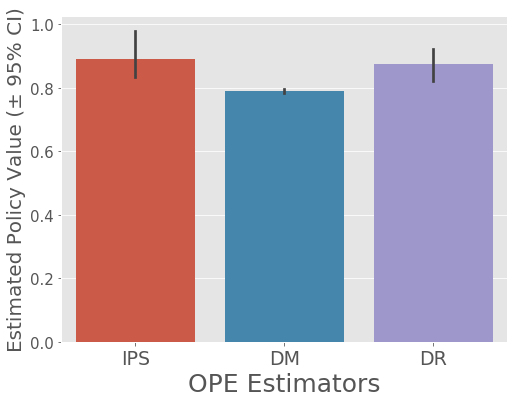

In [31]:
# visualize policy values of the evaluation policy estimated by the three OPE estimators
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

### Evaluation of OPE estimators
Our final step is **the evaluation of OPE**, which evaluates and compares the estimation accuracy of OPE estimators.

With the multi-class classification data, we can calculate the ground-truth policy value of the evaluation policy. 
Therefore, we can compare the policy values estimated by OPE estimators with the ground-turth to evaluate OPE estimators.

**Approximate the Ground-truth Policy Value**

$V(\pi) \approx \frac{1}{|\mathcal{D}_{te}|} \sum_{i=1}^{|\mathcal{D}_{te}|} \mathbb{E}_{a \sim \pi(a|x_i)} [r(x_i, a)], \; \, where \; \, r(x,a) := \mathbb{E}_{r \sim p(r|x,a)} [r]$

In [27]:
# calculate the ground-truth performance of the evaluation policy
true_policy_value = dataset.calc_ground_truth_policy_value(action_dist=action_dist)

true_policy_value

0.8770906200317964

**Evaluation of OPE**

Now, let's evaluate the OPE performance (estimation accuracy) of the three estimators 

$SE (\hat{V}; \mathcal{D}_0) := \left( V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_0, \theta) \right)^2$,     (squared error of $\hat{V}$)

In [28]:
squared_errors = ope.evaluate_performance_of_estimators(
    ground_truth_policy_value=true_policy_value,
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards,
    metric="se", # squared error
)

In [29]:
squared_errors # DR is the most accurate 

{'DM': 0.007904738337954055,
 'DR': 4.34888065560631e-06,
 'IPS': 0.0001737747357629922}

We can iterate the above process several times and calculate the following MSE

$MSE (\hat{V}) := T^{-1} \sum_{t=1}^T SE (\hat{V}; \mathcal{D}_0^{(t)}) $

where $\mathcal{D}_0^{(t)}$ is the synthetic data in the $t$-th iteration

## OBP Library Workshop Tutorial on ZOZOTOWN Open-Bandit Dataset

This section demonstrates an example of conducting OPE of Bernoulli Thompson Sampling (BernoulliTS) as an evaluation policy. We use some OPE estimators and logged bandit feedback generated by running the Random policy (behavior policy) on the ZOZOTOWN platform. We also evaluate and compare the OPE performance (accuracy) of several estimators.

The example consists of the follwoing four major steps:
- (1) Data Loading and Preprocessing
- (2) Replicating Production Policy
- (3) Off-Policy Evaluation (OPE)
- (4) Evaluation of OPE

In [32]:
from sklearn.linear_model import LogisticRegression

import obp
from obp.dataset import OpenBanditDataset
from obp.policy import BernoulliTS
from obp.ope import (
    OffPolicyEvaluation, 
    RegressionModel,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust
)

### Data Loading and Preprocessing

`obp.dataset.OpenBanditDataset` is an easy-to-use data loader for Open Bandit Dataset. 

It takes behavior policy ('bts' or 'random') and campaign ('all', 'men', or 'women') as inputs and provides dataset preprocessing.

In [ ]:
# load and preprocess raw data in "All" campaign collected by the Random policy (behavior policy here)
# When `data_path` is not given, this class downloads the small-sized version of the Open Bandit Dataset.
dataset = OpenBanditDataset(behavior_policy='random', campaign='all')

# obtain logged bandit feedback generated by behavior policy
bandit_feedback = dataset.obtain_batch_bandit_feedback()

the logged bandit feedback is collected by the behavior policy as follows.

$ \mathcal{D}_b := \{(x_i,a_i,r_i)\}$  where $(x,a,r) \sim p(x)\pi_b(a \mid x)p(r \mid x,a) $

In [35]:
# `bandit_feedback` is a dictionary storing logged bandit feedback
bandit_feedback.keys()

dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

### let's see some properties of the dataset class

In [36]:
# name of the dataset is 'obd' (open bandit dataset)
dataset.dataset_name

'obd'

In [37]:
# number of actions of the "All" campaign is 80
dataset.n_actions

80

In [38]:
# small sample example data has 10,000 samples (or rounds)
dataset.n_rounds

10000

In [39]:
# default context (feature) engineering creates context vector with 20 dimensions
dataset.dim_context

20

In [40]:
# ZOZOTOWN recommendation interface has three positions
# (please see https://github.com/st-tech/zr-obp/blob/master/images/recommended_fashion_items.png)
dataset.len_list

3

### Replicating Production Policy

After preparing the dataset, we now replicate the BernoulliTS policy implemented on the ZOZOTOWN recommendation interface during the data collection period.

Here, we use `obp.policy.BernoulliTS` as an evaluation policy. 
By activating its `is_zozotown_prior` argument, we can replicate (the policy parameters of) BernoulliTS used in the ZOZOTOWN production.

(When `is_zozotown_prior=False`, non-informative prior distribution is used.)

In [41]:
# define BernoulliTS as an evaluation policy
evaluation_policy = BernoulliTS(
    n_actions=dataset.n_actions, 
    len_list=dataset.len_list, 
    is_zozotown_prior=True, # replicate the BernoulliTS policy in the ZOZOTOWN production
    campaign="all",
    random_state=12345,
)

# compute the action choice probabilities of the evaluation policy using Monte Carlo simulation
action_dist = evaluation_policy.compute_batch_action_dist(
    n_sim=100000, n_rounds=bandit_feedback["n_rounds"],
)

In [42]:
# action_dist is an array of shape (n_rounds, n_actions, len_list) 
# representing the distribution over actions by the evaluation policy
action_dist

array([[[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       [[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       [[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       ...,

       [[0.01078, 0.00931, 0.00917],
        [0.00167, 0.00077, 0.00076],
        [0.0058 , 0.00614, 0.00631],
        ...,
        [0.0008 , 0.00087, 0.00071],
        [0.00689, 0.00724, 0.00755],
        [0.0582 , 0.07603, 0.07998]],

       [[0.01078, 0.00931, 0.00917],
  

### Obtaining a Reward Estimator
A reward estimator $\hat{q}(x,a)$ is needed for model dependent estimators such as DM or DR.

$\hat{q}(x,a) \approx \mathbb{E} [r \mid x,a]$

In [43]:
# estimate the expected reward by using an ML model (Logistic Regression here)
# the estimated rewards are used by model-dependent estimators such as DM and DR
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    action_context=dataset.action_context,
    base_model=LogisticRegression(max_iter=1000, random_state=12345),
)

In [44]:
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback["context"],
    action=bandit_feedback["action"],
    reward=bandit_feedback["reward"],
    position=bandit_feedback["position"],
    pscore=bandit_feedback["pscore"],
    n_folds=3, # use 3-fold cross-fitting
    random_state=12345,
)

please refer to https://arxiv.org/abs/2002.08536 about the details of the cross-fitting procedure.

### Off-Policy Evaluation (OPE)
Our next step is OPE, which attempts to estimate the performance of evaluation policies using the logged bandit feedback and OPE estimators.

Here, we use 
- `obp.ope.InverseProbabilityWeighting` (IPW)
- `obp.ope.DirectMethod` (DM)
- `obp.ope.DoublyRobust` (DR)

as estimators and visualize the OPE results.

$V(\pi_e) \approx \hat{V} (\pi_e; \mathcal{D}_b, \theta)$ using DM, IPW, and DR

In [45]:
# estimate the policy value of BernoulliTS based on its action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
)

# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
estimated_policy_value, estimated_interval = ope.summarize_off_policy_estimates(
    action_dist=action_dist, 
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure.
    random_state=12345,
)

In [46]:
# the estimated policy value of the evaluation policy (the BernoulliTS policy)
# relative_estimated_policy_value is the policy value of the evaluation policy 
# relative to the ground-truth policy value of the behavior policy (the Random policy here)
estimated_policy_value

,estimated_policy_value,relative_estimated_policy_value
ipw,0.004553,1.198126
dm,0.003385,0.890756
dr,0.004648,1.223157


In [47]:
# confidence intervals of policy value of BernoulliTS estimated by OPE estimators
# (`mean` values in this dataframe is also estimated via the non-parametric bootstrap procedure 
# and is a bit different from the above values in `estimated_policy_value`)
estimated_interval

,mean,95.0% CI (lower),95.0% CI (upper)
ipw,0.004544,0.001531,0.009254
dm,0.003385,0.003337,0.003433
dr,0.004639,0.001625,0.009323


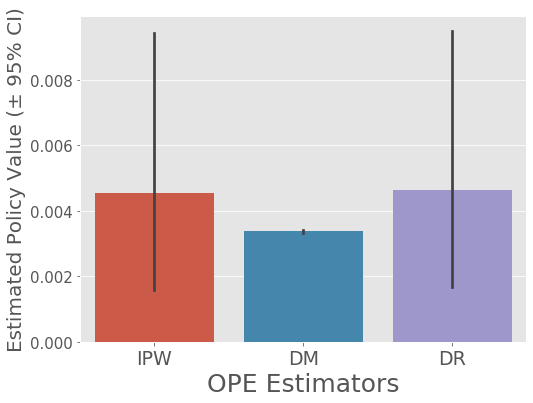

In [48]:
# visualize the policy values of BernoulliTS estimated by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

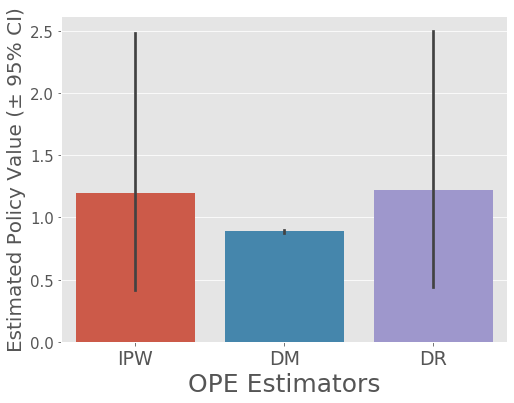

In [49]:
# by activating the `is_relative` option
# we can visualize the estimated policy value of the evaluation policy
# relative to the ground-truth policy value of the behavior policy
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    is_relative=True,
    random_state=12345,
)

Note that the OPE demonstration here is with the small size example version of our dataset. 

Please use its full size version (https://research.zozo.com/data.html) to produce more reasonable results.

### Evaluation of OPE

Our final step is the **evaluation of OPE**, which evaluates the estimation accuracy of OPE estimators.

Specifically, we asses the accuracy of the estimator such as DM, IPW, and DR by comparing its estimation with the ground-truth policy value estimated via the on-policy estimation from the Open Bandit Dataset.

This type of evaluation of OPE is possible, because Open Bandit Dataset contains a set of *multiple* different logged bandit feedback datasets collected by running different policies on the same platform at the same time.

Please refer to [the documentation](https://zr-obp.readthedocs.io/en/latest/evaluation_ope.html) for the details about the evaluation of OPE protocol.

**Approximate the Ground-truth Policy Value**
With Open Bandit Dataset, we can estimate the ground-truth policy value of the evaluation policy in an on-policy manner as follows.

$V(\pi_e) \approx \frac{1}{|\mathcal{D}_{e}|} \sum_{i=1}^{|\mathcal{D}_{e}|} \mathbb{E}_{n} [r_i]$

$ \mathcal{D}_e := \{(x_i,a_i,r_i)\} $ ($(x,a,r) \sim p(x)\pi_e(a \mid x)p(r \mid x,a) $) is the log data collected by the evaluation policy (, which is used only for approximating the ground-truth policy value).

We can compare the policy values estimated by OPE estimators with this on-policy estimate to evaluate the accuracy of OPE.

In [ ]:
# we first calculate the ground-truth policy value of the evaluation policy
# , which is estimated by averaging the factual (observed) rewards contained in the dataset (on-policy estimation)
policy_value_bts = OpenBanditDataset.calc_on_policy_policy_value_estimate(
    behavior_policy='bts', campaign='all'
)

**Evaluation of OPE**

We can evaluate the estimation performance of OPE estimators by comparing the estimated policy values of the evaluation with its ground-truth as follows.

- $\textit{relative-ee} (\hat{V}; \mathcal{D}_b) := \left| \frac{V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b)}{V(\pi_e)} \right|$ (relative estimation error; relative-ee)
- $\textit{SE} (\hat{V}; \mathcal{D}_b) := \left( V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b) \right)^2$ (squared error; se)

In [51]:
# evaluate the estimation performance of OPE estimators 
# `evaluate_performance_of_estimators` returns a dictionary containing estimation performance of given estimators 
relative_ee = ope.summarize_estimators_comparison(
    ground_truth_policy_value=policy_value_bts,
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee

,relative-ee
ipw,0.084019
dm,0.194078
dr,0.106666


We can iterate the above process several times to get more relibale results.

Please see [examples/obd](../obd) for a more sophisticated example of the evaluation of OPE with the Open Bandit Dataset.

## Real-world Example

**"What is the best new policy for the ZOZOTOWN recommendation interface?"**

1. Data Loading and Preprocessing (Random Bucket of Open Bandit Dataset)
2. Off-Policy Learning (IPWLearner and NNPolicyLearner)
3. Off-Policy Evaluation (IPWLearner vs NNPolicyLearner)

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import obp
from obp.dataset import OpenBanditDataset
from obp.policy import IPWLearner, NNPolicyLearner
from obp.ope import (
    RegressionModel,
    OffPolicyEvaluation,
    SelfNormalizedInverseProbabilityWeighting as SNIPS,
    DoublyRobust as DR,
)

### Data Loading and Preprocessing

Here we use a random bucket of the Open Bandit Pipeline. We can download this by using `obp.dataset.OpenBanditDataset`.

In [ ]:
# define OpenBanditDataset class to handle the real bandit data
dataset = OpenBanditDataset(
    behavior_policy="random", campaign="all"
)

In [56]:
# logged bandit data collected by the uniform random policy
training_bandit_data, test_bandit_data = dataset.obtain_batch_bandit_feedback(
    test_size=0.3, is_timeseries_split=True,
)

In [57]:
# ignore the position effect for a demo purpose
training_bandit_data["position"] = None 
test_bandit_data["position"] = None

In [58]:
# number of actions
dataset.n_actions

80

In [59]:
# sample size
dataset.n_rounds

10000

### Off-Policy Learning (OPL)

Train two new policies: `obp.policy.IPWLearner` and `obp.policy.NNPolicyLearner`.

#### IPWLearner

In [60]:
ipw_learner = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=RandomForestClassifier(
        n_estimators=100, max_depth=5, min_samples_leaf=10, random_state=12345
    ),
)

In [61]:
# fit
ipw_learner.fit(
    context=training_bandit_data["context"], # context; x
    action=training_bandit_data["action"], # action; a
    reward=training_bandit_data["reward"], # reward; r
    pscore=training_bandit_data["pscore"], # propensity score; pi_b(a|x)
)

In [62]:
# predict (make new decisions)
action_dist_ipw = ipw_learner.predict(
    context=test_bandit_data["context"]
)

#### NNPolicyLearner

In [63]:
nn_learner = NNPolicyLearner(
    n_actions=dataset.n_actions,
    dim_context=dataset.dim_context,
    solver="adam",
    off_policy_objective="ipw", # = ips
    batch_size=32, 
    random_state=12345,
)

In [64]:
# fit
nn_learner.fit(
    context=training_bandit_data["context"], # context; x
    action=training_bandit_data["action"], # action; a
    reward=training_bandit_data["reward"], # reward; r
    pscore=training_bandit_data["pscore"], # propensity score; pi_b(a|x)
)

policy learning: 100%|██████████| 200/200 [00:00<00:00, 203.25it/s]


In [65]:
# predict (make new decisions)
action_dist_nn = nn_learner.predict(
    context=test_bandit_data["context"]
)

### Obtain a Reward Estimator
`obp.ope.RegressionModel` simplifies the process of reward modeling

$r(x,a) = \mathbb{E} [r \mid x, a] \approx \hat{r}(x,a)$

In [66]:
regression_model = RegressionModel(
    n_actions=dataset.n_actions, 
    base_model=LogisticRegression(C=100, max_iter=500, random_state=12345),
)

In [67]:
estimated_rewards = regression_model.fit_predict(
    context=test_bandit_data["context"], 
    action=test_bandit_data["action"], 
    reward=test_bandit_data["reward"], 
    random_state=12345,
)

### Off-Policy Evaluation

Estimating the performance of IPWLearner and NNPolicyLearner via OPE.

`obp.ope.OffPolicyEvaluation` simplifies the OPE process

$V(\pi_e) \approx \hat{V} (\pi_e; \mathcal{D}_0, \theta)$ using DM, IPS, and DR

In [68]:
ope = OffPolicyEvaluation(
    bandit_feedback=test_bandit_data,
    ope_estimators=[
        SNIPS(estimator_name="SNIPS"),
        DR(estimator_name="DR"),
    ]
)

### Visualize the OPE results

Output the relative performances of the trained policies compared to the logging policy (uniform random)

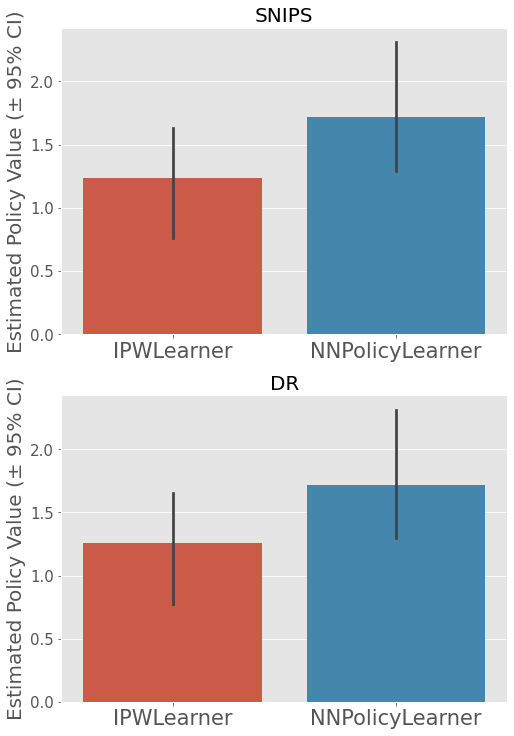

In [ ]:
ope.visualize_off_policy_estimates_of_multiple_policies(
    policy_name_list=["IPWLearner", "NNPolicyLearner"],
    action_dist_list=[action_dist_ipw, action_dist_nn],
    estimated_rewards_by_reg_model=estimated_rewards,
    n_bootstrap_samples=100,
    is_relative=True,
    random_state=12345,
)

Both policy learner outperforms the random baseline. In particular, NNPolicyLearner seems to be the best, improving the random baseline by about 70\%. It also outperforms IPWLearner in both SNIPS and DR.

## Synthetic Slate Dataset

This section provides an example of conducting OPE of several different evaluation policies with synthetic slate bandit feedback data.

Our example with synthetic bandit data contains the follwoing four major steps:
- (1) Synthetic Slate Data Generation
- (2) Defining Evaluation Policy
- (3) Off-Policy Evaluation
- (4) Evaluation of OPE Estimators

The second step could be replaced by some Off-Policy Learning (OPL) step, but obp still does not implement any OPL module for slate bandit data. Implementing OPL for slate bandit data is our future work.

In [70]:
import numpy as np
import pandas as pd
import obp

from obp.ope import SlateStandardIPS, SlateIndependentIPS, SlateRewardInteractionIPS, SlateOffPolicyEvaluation
from obp.dataset import (
    logistic_reward_function,
    SyntheticSlateBanditDataset,
)

In [71]:
from itertools import product
from copy import deepcopy

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
import warnings
warnings.filterwarnings('ignore')

### Synthetic Slate Data Generation
We prepare easy-to-use synthetic slate data generator: `SyntheticSlateBanditDataset` class in the dataset module.

It takes the following arguments as inputs and generates a synthetic bandit dataset that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`) and OPE estimators.
- length of a list of actions recommended in each slate. (`len_list`)
- number of unique actions (`n_unique_actions`)
- dimension of context vectors (`dim_context`)
- reward type (`reward_type`)
- reward structure (`reward_structure`)
- click model (`click_model`)
- base reward function (`base_reward_function`)
- behavior policy (`behavior_policy_function`)

We use a uniform random policy as a behavior policy here.

In [74]:
# generate a synthetic bandit dataset with 10 actions
# we use `logistic_reward_function` as the reward function and `linear_behavior_policy_logit` as the behavior policy.
# one can define their own reward function and behavior policy such as nonlinear ones. 

n_unique_action=10
len_list = 3
dim_context = 2
reward_type = "binary"
reward_structure="cascade_additive"
click_model=None
random_state=12345
base_reward_function=logistic_reward_function

# obtain  test sets of synthetic logged bandit feedback
n_rounds_test = 10000

In [75]:
# define Uniform Random Policy as a baseline behavior policy
dataset_with_random_behavior = SyntheticSlateBanditDataset(
    n_unique_action=n_unique_action,
    len_list=len_list,
    dim_context=dim_context,
    reward_type=reward_type,
    reward_structure=reward_structure,
    click_model=click_model,
    random_state=random_state,
    behavior_policy_function=None,  # set to uniform random
    base_reward_function=base_reward_function,
)

# compute the factual action choice probabililties for the test set of the synthetic logged bandit feedback
bandit_feedback_with_random_behavior = dataset_with_random_behavior.obtain_batch_bandit_feedback(
    n_rounds=n_rounds_test,
    return_pscore_item_position=True,
)

# print policy value
random_policy_value = dataset_with_random_behavior.calc_on_policy_policy_value(
    reward=bandit_feedback_with_random_behavior["reward"],
    slate_id=bandit_feedback_with_random_behavior["slate_id"],
)
print(random_policy_value)

[sample_action_and_obtain_pscore]: 100%|██████████| 10000/10000 [00:04<00:00, 2033.87it/s]


1.8366


### Evaluation Policy Definition (Off-Policy Learning)
 After generating synthetic data, we now define the evaluation policy as follows:
 
1. Generate logit values of three valuation policies (`random`, `optimal`, and `anti-optimal`).
  - A `optimal` policy is defined by a policy that samples actions using`3 * base_expected_reward`.
  - An `anti-optimal` policy is defined by a policy that samples actions using the sign inversion of `-3 * base_expected_reward`.
2. Obtain pscores of the evaluation policies by `obtain_pscore_given_evaluation_policy_logit` method.

In [76]:
random_policy_logit_ = np.zeros((n_rounds_test, n_unique_action))

In [77]:
base_expected_reward = dataset_with_random_behavior.base_reward_function(
    context=bandit_feedback_with_random_behavior["context"],
    action_context=dataset_with_random_behavior.action_context,
    random_state=dataset_with_random_behavior.random_state,
)

In [78]:
optimal_policy_logit_ = base_expected_reward * 3
anti_optimal_policy_logit_ = -3 * base_expected_reward

In [79]:
random_policy_pscores = dataset_with_random_behavior.obtain_pscore_given_evaluation_policy_logit(
    action=bandit_feedback_with_random_behavior["action"],
    evaluation_policy_logit_=random_policy_logit_
)

[obtain_pscore_given_evaluation_policy_logit]: 100%|██████████| 10000/10000 [00:23<00:00, 418.87it/s]


In [80]:
optimal_policy_pscores = dataset_with_random_behavior.obtain_pscore_given_evaluation_policy_logit(
    action=bandit_feedback_with_random_behavior["action"],
    evaluation_policy_logit_=optimal_policy_logit_
)

[obtain_pscore_given_evaluation_policy_logit]: 100%|██████████| 10000/10000 [00:28<00:00, 356.59it/s]


In [81]:
anti_optimal_policy_pscores = dataset_with_random_behavior.obtain_pscore_given_evaluation_policy_logit(
    action=bandit_feedback_with_random_behavior["action"],
    evaluation_policy_logit_=anti_optimal_policy_logit_
)

[obtain_pscore_given_evaluation_policy_logit]: 100%|██████████| 10000/10000 [00:28<00:00, 355.28it/s]


### Off-Policy Evaluation (OPE)
Our next step is OPE which attempts to estimate the performance of evaluation policies using the logged bandit feedback and OPE estimators.

Here, we use the **SlateStandardIPS (SIPS)**, **SlateIndependentIPS (IIPS)**, and **SlateRewardInteractionIPS (RIPS)** estimators and visualize the OPE results.

In [82]:
# estimate the policy value of the evaluation policies based on their action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument

sips = SlateStandardIPS(len_list=len_list)
iips = SlateIndependentIPS(len_list=len_list)
rips = SlateRewardInteractionIPS(len_list=len_list)

ope = SlateOffPolicyEvaluation(
    bandit_feedback=bandit_feedback_with_random_behavior,
    ope_estimators=[sips, iips, rips]
)

          mean  95.0% CI (lower)  95.0% CI (upper) policy_name
sips  1.836816            1.8205          1.852505      random
iips  1.836816            1.8205          1.852505      random
rips  1.836816            1.8205          1.852505      random 



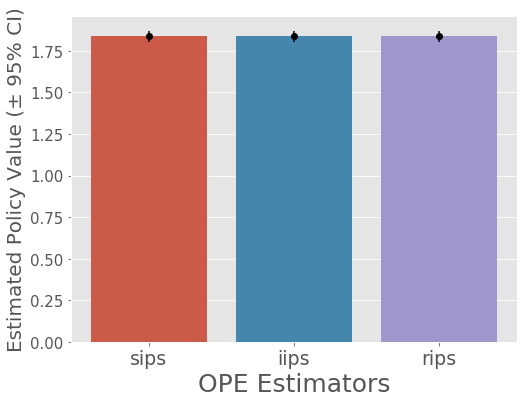

In [83]:
_, estimated_interval_random = ope.summarize_off_policy_estimates(
    evaluation_policy_pscore=random_policy_pscores[0],
    evaluation_policy_pscore_item_position=random_policy_pscores[1],
    evaluation_policy_pscore_cascade=random_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000,
    random_state=dataset_with_random_behavior.random_state,
)
estimated_interval_random["policy_name"] = "random"

print(estimated_interval_random, '\n')
# visualize estimated policy values of Uniform Random by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    evaluation_policy_pscore=random_policy_pscores[0],
    evaluation_policy_pscore_item_position=random_policy_pscores[1],
    evaluation_policy_pscore_cascade=random_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000, # number of resampling performed in the bootstrap procedure
    random_state=dataset_with_random_behavior.random_state,
)

          mean  95.0% CI (lower)  95.0% CI (upper) policy_name
sips  1.830555          1.803695          1.860548     optimal
iips  1.843117          1.825576          1.859695     optimal
rips  1.838866          1.815574          1.862451     optimal 



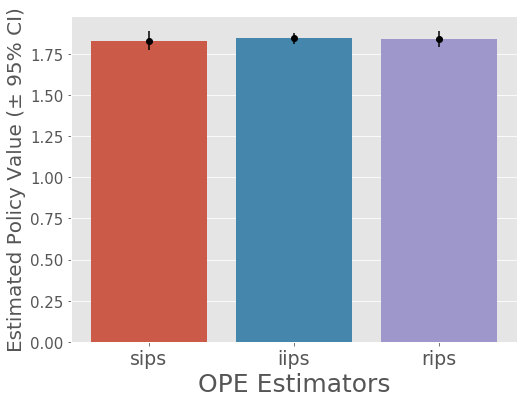

In [84]:
_, estimated_interval_optimal = ope.summarize_off_policy_estimates(
    evaluation_policy_pscore=optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=optimal_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000,
    random_state=dataset_with_random_behavior.random_state,
)

estimated_interval_optimal["policy_name"] = "optimal"

print(estimated_interval_optimal, '\n')
# visualize estimated policy values of Optimal by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    evaluation_policy_pscore=optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=optimal_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000, # number of resampling performed in the bootstrap procedure
    random_state=dataset_with_random_behavior.random_state,
)

          mean  95.0% CI (lower)  95.0% CI (upper)   policy_name
sips  1.854516          1.829643          1.877320  anti-optimal
iips  1.832793          1.815842          1.848599  anti-optimal
rips  1.844397          1.824965          1.864795  anti-optimal 



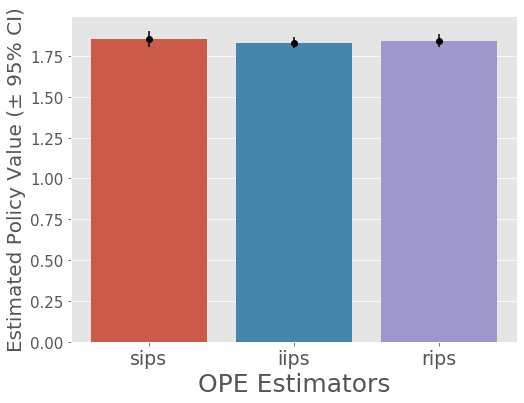

In [85]:
_, estimated_interval_anti_optimal = ope.summarize_off_policy_estimates(
    evaluation_policy_pscore=anti_optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=anti_optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=anti_optimal_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000,
    random_state=dataset_with_random_behavior.random_state,
)
estimated_interval_anti_optimal["policy_name"] = "anti-optimal"

print(estimated_interval_anti_optimal, '\n')
# visualize estimated policy values of Anti-optimal by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    evaluation_policy_pscore=anti_optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=anti_optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=anti_optimal_policy_pscores[2],
    alpha=0.05,
    n_bootstrap_samples=1000, # number of resampling performed in the bootstrap procedure
    random_state=dataset_with_random_behavior.random_state,
)

### Evaluation of OPE estimators
Our final step is **the evaluation of OPE**, which evaluates and compares the estimation accuracy of OPE estimators.

With synthetic slate data, we can calculate the policy value of the evaluation policies. 
Therefore, we can compare the policy values estimated by OPE estimators with the ground-turths to evaluate the accuracy of OPE.

In [86]:
ground_truth_policy_value_random = dataset_with_random_behavior.calc_ground_truth_policy_value(
    context=bandit_feedback_with_random_behavior["context"],
    evaluation_policy_logit_=random_policy_logit_
)
ground_truth_policy_value_random

[calc_ground_truth_policy_value (pscore)]: 100%|██████████| 10000/10000 [00:10<00:00, 930.45it/s]
[calc_ground_truth_policy_value (expected reward), batch_size=3334]: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


1.837144428308276

In [87]:
ground_truth_policy_value_optimal = dataset_with_random_behavior.calc_ground_truth_policy_value(
    context=bandit_feedback_with_random_behavior["context"],
    evaluation_policy_logit_=optimal_policy_logit_
)
ground_truth_policy_value_optimal

[calc_ground_truth_policy_value (pscore)]: 100%|██████████| 10000/10000 [00:12<00:00, 774.03it/s]
[calc_ground_truth_policy_value (expected reward), batch_size=3334]: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


1.8474242800908984

In [88]:
ground_truth_policy_value_anti_optimal = dataset_with_random_behavior.calc_ground_truth_policy_value(
    context=bandit_feedback_with_random_behavior["context"],
    evaluation_policy_logit_=anti_optimal_policy_logit_
)
ground_truth_policy_value_anti_optimal

[calc_ground_truth_policy_value (pscore)]: 100%|██████████| 10000/10000 [00:12<00:00, 786.50it/s]
[calc_ground_truth_policy_value (expected reward), batch_size=3334]: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


1.8352871486686428

In [89]:
estimated_interval_random["ground_truth"] = ground_truth_policy_value_random
estimated_interval_optimal["ground_truth"] = ground_truth_policy_value_optimal
estimated_interval_anti_optimal["ground_truth"] = ground_truth_policy_value_anti_optimal

estimated_intervals = pd.concat(
    [
        estimated_interval_random,
        estimated_interval_optimal,
        estimated_interval_anti_optimal
    ]
)

In [90]:
estimated_intervals

,mean,95.0% CI (lower),95.0% CI (upper),policy_name,ground_truth
sips,1.836816,1.820500,1.852505,random,1.837144
iips,1.836816,1.820500,1.852505,random,1.837144
rips,1.836816,1.820500,1.852505,random,1.837144
sips,1.830555,1.803695,1.860548,optimal,1.847424
iips,1.843117,1.825576,1.859695,optimal,1.847424
rips,1.838866,1.815574,1.862451,optimal,1.847424
sips,1.854516,1.829643,1.877320,anti-optimal,1.835287
iips,1.832793,1.815842,1.848599,anti-optimal,1.835287
rips,1.844397,1.824965,1.864795,anti-optimal,1.835287


We can confirm that the three OPE estimators return the same results when the behavior policy and the evaluation policy is the same, and the estimates are quite similar to the `random_policy_value` calcurated above.

We can also observe that the performance of OPE estimators are as follows in this simulation: `IIPS > RIPS > SIPS`.

In [91]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy values and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 

relative_ee_for_random_evaluation_policy = ope.summarize_estimators_comparison(
    ground_truth_policy_value=ground_truth_policy_value_random,
    evaluation_policy_pscore=random_policy_pscores[0],
    evaluation_policy_pscore_item_position=random_policy_pscores[1],
    evaluation_policy_pscore_cascade=random_policy_pscores[2],
)
relative_ee_for_random_evaluation_policy

,relative-ee
sips,0.000296
iips,0.000296
rips,0.000296


In [92]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy values and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 

relative_ee_for_optimal_evaluation_policy = ope.summarize_estimators_comparison(
    ground_truth_policy_value=ground_truth_policy_value_optimal,
    evaluation_policy_pscore=optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=optimal_policy_pscores[2],
)
relative_ee_for_optimal_evaluation_policy

,relative-ee
sips,0.009303
iips,0.002470
rips,0.004732


In [93]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy values and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 

relative_ee_for_anti_optimal_evaluation_policy = ope.summarize_estimators_comparison(
    ground_truth_policy_value=ground_truth_policy_value_anti_optimal,
    evaluation_policy_pscore=anti_optimal_policy_pscores[0],
    evaluation_policy_pscore_item_position=anti_optimal_policy_pscores[1],
    evaluation_policy_pscore_cascade=anti_optimal_policy_pscores[2],
)
relative_ee_for_anti_optimal_evaluation_policy

,relative-ee
sips,0.010281
iips,0.001506
rips,0.004751


The variance of OPE estimators is as follows: `SIPS > RIPS > IIPS`.

In [94]:
estimated_intervals["errbar_length"] = (
    estimated_intervals.drop(["mean", "policy_name", "ground_truth"], axis=1).diff(axis=1).iloc[:, -1].abs()
)

(1.7, 1.9)

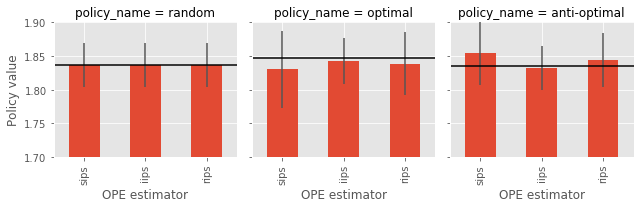

In [95]:
alpha = 0.05
plt.style.use("ggplot")

def errplot(x, y, yerr, **kwargs):
    ax = plt.gca()
    data = kwargs.pop("data")
    data.plot(x=x, y=y, yerr=yerr, kind="bar", ax=ax, **kwargs)
    ax.hlines(data["ground_truth"].iloc[0], -1, len(x)+1)
#     ax.set_xlabel("OPE estimator")
    
g = sns.FacetGrid(
    estimated_intervals.reset_index().rename(columns={"index": "OPE estimator", "mean": "Policy value"}),
    col="policy_name"
)
g.map_dataframe(errplot, "OPE estimator", "Policy value", "errbar_length")
plt.ylim((1.7, 1.9))

It is surprising that `RIPS` estimator does not achieve the best performance even if the reward structure is not independent. If we run a simulation where the reward of each position depends heavily on those of other positions, `RIPS`estimator could achieve the best performance.

## Off-Policy Evaluation of Online Bandit Algorithms

This section provides an example of conducting OPE of online bandit algorithms using Replay Method (RM) with synthetic bandit feedback data.
RM uses a subset of the logged bandit feedback data where actions selected by the behavior policy are the same as that of the evaluation policy.
Theoretically, RM is unbiased when the behavior policy is uniformly random and the evaluation policy is fixed.
However, empirically, RM works well when evaluation policies are learning algorithms.
Please refer to https://arxiv.org/abs/1003.5956 about the details of RM.

Our example with online bandit algorithms contains the follwoing three major steps:
- (1) Synthetic Data Generation
- (2) Off-Policy Evaluation (OPE)
- (3) Evaluation of OPE

In [96]:
import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function
)
from obp.policy import EpsilonGreedy, LinTS, LinUCB
from obp.ope import (
    OffPolicyEvaluation, 
    ReplayMethod
)
from obp.simulator import (
    calc_ground_truth_policy_value,
    run_bandit_simulation
)

### Synthetic Data Generation
We prepare easy-to-use synthetic data generator: `SyntheticBanditDataset` class in the dataset module.

It takes number of actions (`n_actions`), dimension of context vectors (`dim_context`), reward function (`reward_function`), and behavior policy (`behavior_policy_function`) as inputs and generates a synthetic bandit dataset that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`) and OPE estimators.

In [97]:
# generate a synthetic bandit dataset with 10 actions
# we use `logistic function` as the reward function
# we use the uniformly random behavior policy because it is desriable for RM
# one can define their own reward function and behavior policy such as nonlinear ones. 
dataset = SyntheticBanditDataset(
    n_actions=10,
    dim_context=5,
    reward_type="binary", # "binary" or "continuous"
    reward_function=logistic_reward_function,
    behavior_policy_function=None, # uniformly random
    random_state=12345,
)
# obtain a set of synthetic logged bandit feedback
n_rounds = 10000
bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds)

# `bandit_feedback` is a dictionary storing synthetic logged bandit feedback
bandit_feedback

{'action': array([6, 4, 2, ..., 9, 4, 7]),
 'action_context': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 'context': array([[-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057],
        [ 1.39340583,  0.09290788,  0.28174615,  0.76902257,  1.24643474],
        [ 1.00718936, -1.29622111,  0.27499163,  0.22891288,  1.35291684],
        ...,
        [-1.27028221,  0.80914602, -0.45084222,  0.47179511,  1.89401115],
        [-0.68890924,  0.08857502, -0.56359347, -0.41135069,  0.65157486],
        [ 0.51204121,  0.65384817, -1.98849253, -2.14429131, -0.34186901]]),
 'expected_reward': array([[0.80210203, 0.73828559, 0.8319955

### Off-Policy Evaluation (OPE)
Our next step is OPE which attempts to estimate the performance of online bandit algorithms using the logged bandit feedback and RM.

Here, we visualize the OPE results.

In [98]:
# simulations of online bandit algorithms
# obtain a deterministic action distribution representing which action is selected at each round in the simulation
# policies are updated only when the selected action is the same as that of the logged data
epsilon_greedy = EpsilonGreedy(
    n_actions=dataset.n_actions,
    epsilon=0.1,
    random_state=12345
)
action_dist_epsilon_greedy = run_bandit_simulation(
    bandit_feedback=bandit_feedback,
    policy=epsilon_greedy
)

lin_ts = LinTS(
    dim=dataset.dim_context,
    n_actions=dataset.n_actions,
    random_state=12345
)
action_dist_lin_ts = run_bandit_simulation(
    bandit_feedback=bandit_feedback,
    policy=lin_ts
)

lin_ucb = LinUCB(
    dim=dataset.dim_context,
    n_actions=dataset.n_actions,
    random_state=12345
)
action_dist_lin_ucb = run_bandit_simulation(
    bandit_feedback=bandit_feedback,
    policy=lin_ucb
)

100%|██████████| 10000/10000 [00:01<00:00, 6985.13it/s]


In [99]:
# estimate the policy value of the online bandit algorithms using RM
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[ReplayMethod()]
)

    95.0% CI (lower)  95.0% CI (upper)      mean
rm            0.5702          0.658162  0.613388 



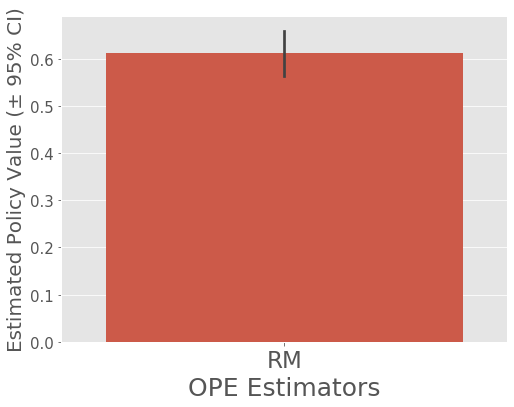

In [100]:
# estimate the policy value of EpsilonGreedy
estimated_policy_value_epsilon_greedy, estimated_interval_epsilon_greedy = ope.summarize_off_policy_estimates(
    action_dist=action_dist_epsilon_greedy
)
print(estimated_interval_epsilon_greedy, '\n')

# visualize estimated policy values of EpsilonGreedy by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist_epsilon_greedy,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

    95.0% CI (lower)  95.0% CI (upper)     mean
rm          0.611872          0.713379  0.66498 



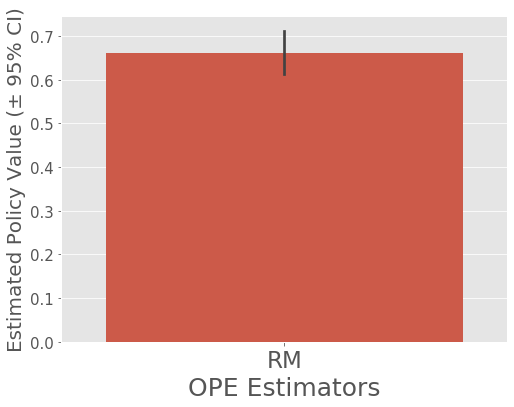

In [101]:
# estimate the policy value of LinTS
estimated_policy_value_lin_ts, estimated_interval_lin_ts = ope.summarize_off_policy_estimates(
    action_dist=action_dist_lin_ts
)
print(estimated_interval_lin_ts, '\n')

# visualize estimated policy values of LinTS by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist_lin_ts,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

    95.0% CI (lower)  95.0% CI (upper)     mean
rm          0.597293          0.677215  0.64061 



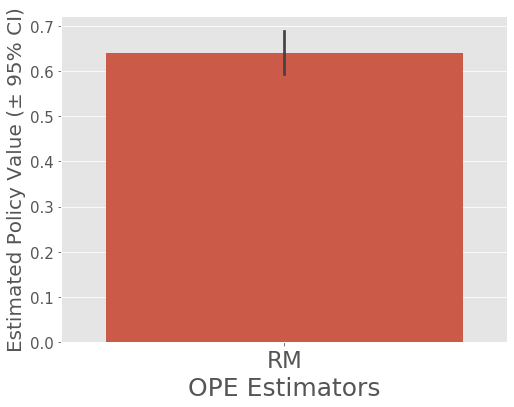

In [102]:
# estimate the policy value of LinUCB
estimated_policy_value_lin_ucb, estimated_interval_lin_ucb = ope.summarize_off_policy_estimates(
    action_dist=action_dist_lin_ucb
)
print(estimated_interval_lin_ucb, '\n')

# visualize estimated policy values of LinUCB by the three OPE estimators
# and their 95% confidence intervals (estimated by nonparametric bootstrap method)
ope.visualize_off_policy_estimates(
    action_dist=action_dist_lin_ucb,
    n_bootstrap_samples=10000, # number of resampling performed in the bootstrap procedure
    random_state=12345,
)

RM estimates that LinTS is the best policy.

### Evaluation of OPE
Our final step is **the evaluation of OPE**, which evaluates and compares the estimation accuracy of OPE estimators.

With synthetic data, we can calculate the policy value of the evaluation policies. 
Therefore, we can compare the policy values estimated by RM with the ground-turths to evaluate the accuracy of OPE.

In [103]:
# we first calculate the policy values of the three evaluation policies
# in synthetic data, we know p(r|x,a), the reward distribution, so we can perform simulations
# here, a policy is updated at each round according to actions and rewards sampled from the policy and p(r|x,a)
# the policy values are averaged over `n_sim` simulations
policy_value_epsilon_greedy = calc_ground_truth_policy_value(
    bandit_feedback=bandit_feedback,
    reward_sampler=dataset.sample_reward, # p(r|x,a)
    policy=epsilon_greedy,
    n_sim=3 # the number of simulations
)
policy_value_lin_ts = calc_ground_truth_policy_value(
    bandit_feedback=bandit_feedback,
    reward_sampler=dataset.sample_reward, # p(r|x,a)
    policy=lin_ts,
    n_sim=3 # the number of simulations
)
policy_value_lin_ucb = calc_ground_truth_policy_value(
    bandit_feedback=bandit_feedback,
    reward_sampler=dataset.sample_reward, # p(r|x,a)
    policy=lin_ucb,
    n_sim=3 # the number of simulations
)

print(f'policy value of EpsilonGreedy: {policy_value_epsilon_greedy}')
print(f'policy value of LinTS: {policy_value_lin_ts}')
print(f'policy value of LinUCB: {policy_value_lin_ucb}')

100%|██████████| 3/3 [00:20<00:00,  6.93s/it]

policy value of EpsilonGreedy: 0.655486184283327
policy value of LinTS: 0.7323584842875861
policy value of LinUCB: 0.7098538447648373


In fact, LinTS reveals the best performance among the three evaluation policies.

Using the above policy values, we evaluate the estimation accuracy of the OPE estimators.

In [104]:
# evaluate the estimation performances of OPE estimators 
# by comparing the estimated policy values of EpsilonGreedy and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 
relative_ee_epsilon_greedy = ope.summarize_estimators_comparison(
    ground_truth_policy_value=policy_value_epsilon_greedy,
    action_dist=action_dist_epsilon_greedy,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_epsilon_greedy

,relative-ee
rm,0.068046


In [105]:
# evaluate the estimation performance of OPE estimators 
# by comparing the estimated policy values of LinTS t and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 
relative_ee_lin_ts = ope.summarize_estimators_comparison(
    ground_truth_policy_value=policy_value_lin_ts,
    action_dist=action_dist_lin_ts,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_lin_ts

,relative-ee
rm,0.096554


In [106]:
# evaluate the estimation performance of OPE estimators 
# by comparing the estimated policy values of LinUCB and its ground-truth.
# `summarize_estimators_comparison` returns a pandas dataframe containing estimation performances of given estimators 
relative_ee_lin_ucb = ope.summarize_estimators_comparison(
    ground_truth_policy_value=policy_value_lin_ucb,
    action_dist=action_dist_lin_ucb,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_lin_ucb

,relative-ee
rm,0.097352


## Off-Policy Learners

This section provides an example of implementing several off-policy learning methods with synthetic logged bandit data.

The example consists of the follwoing four major steps:
- (1) Generating Synthetic Data
- (2) Off-Policy Learning
- (3) Evaluation of Off-Policy Learners

In [107]:
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression

import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_reward_function,
    linear_behavior_policy
)
from obp.policy import (
    IPWLearner, 
    NNPolicyLearner, 
    Random
)

### Generating Synthetic Data
`obp.dataset.SyntheticBanditDataset` is an easy-to-use synthetic data generator.

It takes 
- number of actions (`n_actions`, $|\mathcal{A}|$)
- dimension of context vectors (`dim_context`, $d$)
- reward function (`reward_function`, $q(x,a)=\mathbb{E}[r \mid x,a]$)
- behavior policy (`behavior_policy_function`, $\pi_b(a|x)$) 

as inputs and generates a synthetic logged bandit data that can be used to evaluate the performance of decision making policies (obtained by `off-policy learning`).

In [108]:
# generate a synthetic bandit dataset with 10 actions
# we use `logistic function` as the reward function and `linear_behavior_policy` as the behavior policy.
# one can define their own reward function and behavior policy such as nonlinear ones. 
dataset = SyntheticBanditDataset(
    n_actions=10,
    dim_context=5,
    tau=0.2, # temperature hyperparameter to control the entropy of the behavior policy
    reward_type="binary", # "binary" or "continuous"
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=12345,
)

In [109]:
# obtain training and test sets of synthetic logged bandit data
n_rounds_train, n_rounds_test = 10000, 10000
bandit_feedback_train = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_train)
bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_test)

the logged bandit data is collected by the behavior policy as follows.

$ \mathcal{D}_b := \{(x_i,a_i,r_i)\}_{i=1}^n$  where $(x,a,r) \sim p(x)\pi_b(a \mid x)p(r \mid x,a) $

In [110]:
# `bandit_feedback` is a dictionary storing synthetic logged bandit feedback
bandit_feedback_train

{'action': array([6, 1, 1, ..., 0, 1, 6]),
 'action_context': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 'context': array([[-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057],
        [ 1.39340583,  0.09290788,  0.28174615,  0.76902257,  1.24643474],
        [ 1.00718936, -1.29622111,  0.27499163,  0.22891288,  1.35291684],
        ...,
        [-1.27028221,  0.80914602, -0.45084222,  0.47179511,  1.89401115],
        [-0.68890924,  0.08857502, -0.56359347, -0.41135069,  0.65157486],
        [ 0.51204121,  0.65384817, -1.98849253, -2.14429131, -0.34186901]]),
 'expected_reward': array([[0.80210203, 0.73828559, 0.8319955

### Off-Policy Learning
After generating synthetic data, we now train some decision making policies.

To train policies, we use

- `obp.policy.NNPolicyLearner` (Neural Network Policy Learner)
- `obp.policy.IPWLearner`

For NN Learner, we use 
- Direct Method ("dm")
- InverseProbabilityWeighting ("ipw")
- DoublyRobust ("dr") 

as its objective functions (`off_policy_objective`). 

For IPW Learner, we use *RandomForestClassifier* and *LogisticRegression* implemented in scikit-learn for base machine learning methods.

A policy is trained by maximizing an OPE estimator as an objective function as follows.

$$ \hat{\pi} \in \arg \max_{\pi \in \Pi} \hat{V} (\pi; \mathcal{D}_{tr}) - \lambda \cdot \Omega (\pi)  $$

where $\hat{V}(\cdot; \mathcal{D})$ is an off-policy objective and $\mathcal{D}_{tr}$ is a training bandit dataset. $\Omega (\cdot)$ is a regularization term.

In [111]:
# define NNPolicyLearner with DM as its objective function
nn_dm = NNPolicyLearner(
    n_actions=dataset.n_actions,
    dim_context=dataset.dim_context,
    off_policy_objective="dm",
    batch_size=64,
    random_state=12345,
)

# train NNPolicyLearner on the training set of logged bandit data
nn_dm.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
)

# obtains action choice probabilities for the test set
action_dist_nn_dm = nn_dm.predict_proba(
    context=bandit_feedback_test["context"]
)

policy learning: 100%|██████████| 200/200 [01:06<00:00,  3.01it/s]


In [112]:
# define NNPolicyLearner with IPW as its objective function
nn_ipw = NNPolicyLearner(
    n_actions=dataset.n_actions,
    dim_context=dataset.dim_context,
    off_policy_objective="ipw",
    batch_size=64,
    random_state=12345,
)

# train NNPolicyLearner on the training set of logged bandit data
nn_ipw.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"],
)

# obtains action choice probabilities for the test set
action_dist_nn_ipw = nn_ipw.predict_proba(
    context=bandit_feedback_test["context"]
)

policy learning: 100%|██████████| 200/200 [00:58<00:00,  3.40it/s]


In [113]:
# define NNPolicyLearner with DR as its objective function
nn_dr = NNPolicyLearner(
    n_actions=dataset.n_actions,
    dim_context=dataset.dim_context,
    off_policy_objective="dr",
    batch_size=64,
    random_state=12345,
)

# train NNPolicyLearner on the training set of logged bandit data
nn_dr.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"],
)

# obtains action choice probabilities for the test set
action_dist_nn_dr = nn_dr.predict_proba(
    context=bandit_feedback_test["context"]
)

policy learning: 100%|██████████| 200/200 [01:21<00:00,  2.46it/s]


In [114]:
# define IPWLearner with Logistic Regression as its base ML model
ipw_lr = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=LogisticRegression(C=100, random_state=12345)
)

# train IPWLearner on the training set of logged bandit data
ipw_lr.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)

# obtains action choice probabilities for the test set
action_dist_ipw_lr = ipw_lr.predict(
    context=bandit_feedback_test["context"]
)

In [115]:
# define IPWLearner with Random Forest as its base ML model
ipw_rf = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=RandomForest(
        n_estimators=30, min_samples_leaf=10, random_state=12345
    )
)

# train IPWLearner on the training set of logged bandit data
ipw_rf.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)

# obtains action choice probabilities for the test set
action_dist_ipw_rf = ipw_rf.predict(
    context=bandit_feedback_test["context"]
)

In [116]:
# define Uniform Random Policy as a baseline evaluation policy
random = Random(n_actions=dataset.n_actions,)

# compute the action choice probabilities for the test set
action_dist_random = random.compute_batch_action_dist(
    n_rounds=bandit_feedback_test["n_rounds"]
)

In [117]:
# action_dist is a probability distribution over actions (can be deterministic)
action_dist_ipw_lr[:, :, 0]

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Evaluation of Off-Policy Learners
Our final step is the evaluation and comparison of the off-policy learnres.

With synthetic data, we can calculate the policy value of the off-policy learners as follows. 

$$V(\pi_e) \approx \frac{1}{|\mathcal{D}_{te}|} \sum_{i=1}^{|\mathcal{D}_{te}|} \mathbb{E}_{a \sim \pi_e(a|x_i)} [q(x_i, a)], \; \, where \; \, q(x,a) := \mathbb{E}_{r \sim p(r|x,a)} [r]$$

where $\mathcal{D}_{te}$ is the test set of logged bandit data.

In [118]:
# we calculate the policy values of the trained policies based on the expected rewards of the test data
policy_names = [
    "NN Policy Learner with DM",
    "NN Policy Learner with IPW",
    "NN Policy Learner with DR",
    "IPW Learner with Logistic Regression",
    "IPW Learner with Random Forest",
    "Unifrom Random"
]
action_dist_list = [
    action_dist_nn_dm,
    action_dist_nn_ipw,
    action_dist_nn_dr,
    action_dist_ipw_lr,
    action_dist_ipw_rf,
    action_dist_random
]

for name, action_dist in zip(policy_names, action_dist_list):
    true_policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=action_dist,
    )
    print(f'policy value of {name}: {true_policy_value}')

policy value of NN Policy Learner with DM: 0.7404426113352143
policy value of NN Policy Learner with IPW: 0.7212314908365143
policy value of NN Policy Learner with DR: 0.7236078671760903
policy value of IPW Learner with Logistic Regression: 0.7225216225722526
policy value of IPW Learner with Random Forest: 0.6826465969408197
policy value of Unifrom Random: 0.6056038101021686


In fact, NNPolicyLearner maximizing the DM estimator seems the best in this simple setting.

We can iterate the above process several times to get more relibale results.